In [1]:
import numpy as np
import matplotlib.pyplot as plt

from simulation import Simulation
from stats import Stats
from constants import STORAGE_IDS, STORAGE_SIZES, MOVIES_IDS, MOVIE_SIZES, STORAGE_HANDLE_TIME_BETA, TIME_INTERVALS, INITIAL_MOVIE_HASHSET
from utils import compute_mean_request_rate, compute_overall_request_rate

%load_ext autoreload
%autoreload 2

In [2]:
def observed_request_rate(requests, total_duration):
    """
    compute the overall request rate (# requests / total duration = sum_node # requests_node / total_duration)
    :param requests: (unfiltered) requests generated by the simulation
    :param total_duration: total duration of the time intervals
    :return: overall request rate
    """
    return len(requests)/total_duration

In [13]:
def observed_max_request_rate(requests):
    rates = []
    for storage_id in STORAGE_IDS:
        for time_interval in TIME_INTERVALS:
            duration = time_interval[1] - time_interval[0]
            filtered_requests = [r for r in requests if r.storage_id == storage_id and time_interval[0] <= r.time_creation <= time_interval[1]]
            rates.append(len(filtered_requests)/duration)
    return max(rates)

In [23]:
def control_variate_estimate(X, Y, mu, compute_transform=False):
    """
    Control variate function to calculate the expected statistics using the mean request rate as a control variate.
    :param X: statistic T(requests) of the requests waiting time per simulation
    :param Y: overall request rate per simulation
    :param mu: theoretical overall request rate
    :return: control estimate of the expected T(requests)
    """
    # linear regression
    X_mean = np.mean(X)
    Y_mean = np.mean(Y)
    delta_X = X - X_mean
    delta_Y = Y - Y_mean

    a = np.sum(delta_X * delta_Y)/np.sum(delta_Y**2)
    b = X_mean - a * Y_mean

    if compute_transform: return b + a*mu, X - a * (Y - mu)
    else: return b + a*mu

## Overall Request Rate

In [10]:
num_simulation = 500
log_every_n_simulations = 25

simulation = Simulation()
movie_hashsets = INITIAL_MOVIE_HASHSET
metric_fct = np.mean
total_duration = TIME_INTERVALS[-1][1] - TIME_INTERVALS[0][0] # end of last interval - start of first interval

metrics = []
control_variates = []

MC_metrics = []
CV_estimates = []
for i in range(num_simulation):
    requests = simulation.run(movie_hashsets=movie_hashsets)

    stats = Stats(requests)
    waiting_times = stats.get_waiting_time()
    metrics.append(metric_fct(waiting_times))
    control_variates.append(observed_request_rate(requests, total_duration))
    
    if (i+1) % log_every_n_simulations == 0 and i > 1:
        MC_metrics.append(np.mean(metrics))
        CV_estimates.append(control_variate_estimate(np.array(metrics), np.array(control_variates), compute_overall_request_rate(movies_hashsets=movie_hashsets)))

Text(0, 0.5, 'Overall Request Rate')

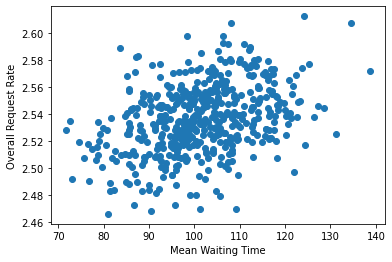

In [12]:
plt.scatter(metrics, control_variates)
plt.xlabel('Mean Waiting Time')
plt.ylabel('Overall Request Rate')

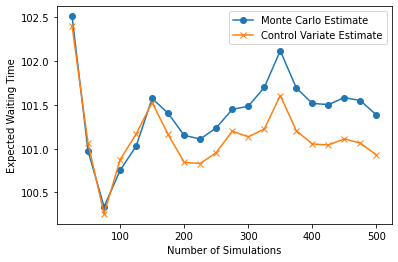

In [11]:
n_sims = np.arange(0, num_simulation+1, log_every_n_simulations)[1:]
plt.plot(n_sims, MC_metrics, label='Monte Carlo Estimate', marker='o')
plt.plot(n_sims, CV_estimates, label='Control Variate Estimate', marker='x')
plt.xlabel('Number of Simulations')
plt.ylabel('Expected Mean Waiting Time')
plt.legend()

## Max Request Rate

In [20]:
num_simulation = 500
log_every_n_simulations = 25

simulation = Simulation()
movie_hashsets = INITIAL_MOVIE_HASHSET
metric_fct = np.mean
mean_request_rate = compute_mean_request_rate(movies_hashsets=movie_hashsets)
mu_CV = np.max(np.array([mean_request_rate[storage_id] for storage_id in STORAGE_IDS]).flatten())

metrics = []
control_variates = []

MC_metrics = []
CV_estimates = []
for i in range(num_simulation):
    requests = simulation.run(movie_hashsets=movie_hashsets)

    stats = Stats(requests)
    waiting_times = stats.get_waiting_time()
    metrics.append(metric_fct(waiting_times))
    control_variates.append(observed_max_request_rate(requests))
    
    if (i+1) % log_every_n_simulations == 0 and i > 1:
        MC_metrics.append(np.mean(metrics))
        CV_estimates.append(control_variate_estimate(np.array(metrics), np.array(control_variates), mu_CV))
        # print(f'MC CV {np.mean(control_variates)}\n mu CV {mu_CV}')

Text(0, 0.5, 'Max Request Rate')

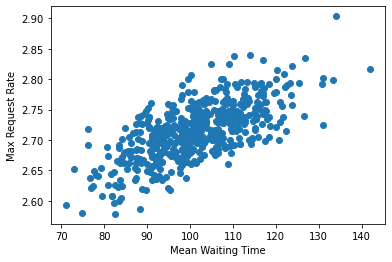

In [21]:
plt.scatter(metrics, control_variates)
plt.xlabel('Mean Waiting Time')
plt.ylabel('Max Request Rate')

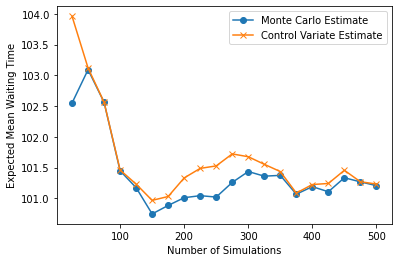

In [22]:
n_sims = np.arange(0, num_simulation+1, log_every_n_simulations)[1:]
plt.plot(n_sims, MC_metrics, label='Monte Carlo Estimate', marker='o')
plt.plot(n_sims, CV_estimates, label='Control Variate Estimate', marker='x')
plt.xlabel('Number of Simulations')
plt.ylabel('Expected Mean Waiting Time')
plt.legend()

In [24]:
num_simulation = 500
log_every_n_simulations = 25

simulation = Simulation()
movie_hashsets = INITIAL_MOVIE_HASHSET
metric_fct = np.mean
mean_request_rate = compute_mean_request_rate(movies_hashsets=movie_hashsets)
mu_CV = np.max(np.array([mean_request_rate[storage_id] for storage_id in STORAGE_IDS]).flatten())

metrics = []
control_variates = []

MC_metrics = []
MC_std = []
CV_estimates = []
CV_std = []
for i in range(num_simulation):
    requests = simulation.run(movie_hashsets=movie_hashsets)

    stats = Stats(requests)
    waiting_times = stats.get_waiting_time()
    metrics.append(metric_fct(waiting_times))
    control_variates.append(observed_max_request_rate(requests))
    
    if (i+1) % log_every_n_simulations == 0 and i > 1:
        MC_metrics.append(np.mean(metrics))
        MC_std.append(np.std(metrics))
        mean_CV, Z = control_variate_estimate(np.array(metrics), np.array(control_variates), mu_CV, compute_transform=True)
        CV_estimates.append(mean_CV)
        CV_std.append(np.std(Z))
        # print(f'MC CV {np.mean(control_variates)}\n mu CV {mu_CV}')

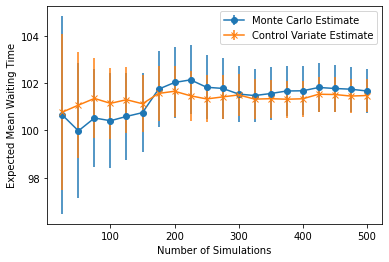

In [27]:
n_sims = np.arange(0, num_simulation+1, log_every_n_simulations)[1:]
plt.errorbar(n_sims, MC_metrics, yerr=1.96*np.array(MC_std)/np.sqrt(n_sims), label='Monte Carlo Estimate', marker='o')
plt.errorbar(n_sims, CV_estimates, yerr=1.96*np.array(CV_std)/np.sqrt(n_sims), label='Control Variate Estimate', marker='x')
plt.xlabel('Number of Simulations')
plt.ylabel('Expected Mean Waiting Time')
plt.legend()